<a href="https://colab.research.google.com/github/kush1912/Phocket---ML-Internship/blob/master/Keyword_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np


In [0]:
df = pd.read_csv('Kaggle.csv')
print(df.shape)
df.head()

(1311, 4)


,_id,headline,pub_date,body
0,5bac1099068401528a2dd1ee,"{""main"":""New Allegation of Drunken Assault Sur...",2018-09-26T23:04:52+0000,WASHINGTON — The U.S. Senate Judiciary Committ...
1,5bac1099068401528a2dd1ef,"{""main"":""Darktrace Hits $1.65 Billion Valuatio...",2018-09-26T23:04:53+0000,(Reuters) - Cyber-security firm Darktrace said...
2,5bac114a068401528a2dd1f0,"{""main"":""Turkey's Erdogan Calls on Germany to ...",2018-09-26T23:07:50+0000,"BERLIN — President Tayyip Erdogan, on the eve ..."
3,5bac114c068401528a2dd1f1,"{""main"":""Italy to Present Budget Targets After...",2018-09-26T23:07:52+0000,ROME — Italy's new government plans to present...
4,5bac117d068401528a2dd1f2,"{""main"":""Trump’s America: Reckless, Alone and ...",2018-09-26T23:08:43+0000,"Trailed by the Russia investigation, back-stab..."


In [0]:
#Fetch wordcount for body and headline
df['word_count_body'] = df['body'].apply(lambda x: len(str(x).split(" ")))
dfb = dfb[['body','word_count_body']]
dfb.head()

,body,word_count_body
0,WASHINGTON — The U.S. Senate Judiciary Committ...,100
1,(Reuters) - Cyber-security firm Darktrace said...,240
2,"BERLIN — President Tayyip Erdogan, on the eve ...",515
3,ROME — Italy's new government plans to present...,434
4,"Trailed by the Russia investigation, back-stab...",892


In [0]:
dfb.word_count_body.describe()

count    1311.000000
mean      557.732265
std       441.778314
min        24.000000
25%       249.500000
50%       456.000000
75%       783.500000
max      5191.000000
Name: word_count_body, dtype: float64

In [0]:
#Identify common words
freq = pd.Series(' '.join(dfb['body']).split()).value_counts()[:20]
freq


the     37356
to      19576
a       18584
of      17391
and     17286
in      14970
that     8313
for      6928
on       6580
was      5656
is       5379
with     5292
The      4925
he       4284
by       4142
at       3953
as       3947
said     3846
his      3710
it       3354
dtype: int64

In [0]:
(import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
stop_words = set(stopwords.words("english"))
#stop_words = stop_words.union(s_w)
corpus = []
for i in range(0,1311 ):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dfb['body'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

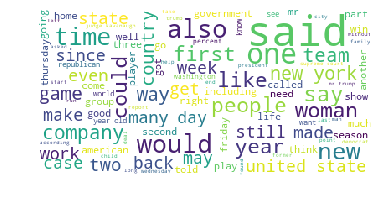

In [0]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.7,min_df = 0.1, stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)

# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
for i in range(5):
  doc =corpus[i]
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  keywords=extract_topn_from_vector(feature_names,sorted_items,10)
  print("\Body:")
  print(doc)
  print("\nKeywords:")
  for k in keywords:
      print(k,keywords[k])
  
  
#doc=corpus[1]
 
#generate tf-idf for the given document
#tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

\Body:
washington u senate judiciary committee looking least one additional allegation misconduct supreme court nominee brett kavanaugh nbc news reported wednesday according anonymous complaint letter sent republican senator cory gardner kavanaugh physically assaulted woman socialized washington area inebriated nbc news said citing letter multiple people familiar process kavanaugh denied allegation letter call tuesday committee staff nbc news said citing unnamed source reporting eric beech editing mohammad zargham

Keywords:
kavanaugh 0.453
news 0.386
allegation 0.296
committee 0.289
washington 0.246
nominee 0.161
looking 0.16
process 0.156
area 0.154
brett kavanaugh 0.151
\Body:
reuters cyber security firm darktrace said wednesday raised million latest funding round led european private equity firm vitruvian partner llp valuing company billion series e funding round also included existing investor kkr co inc teneleven venture company founded raised total million far chief executive of

In [0]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
  
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\Body:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])

\Body:
reuters cyber security firm darktrace said wednesday raised million latest funding round led european private equity firm vitruvian partner llp valuing company billion series e funding round also included existing investor kkr co inc teneleven venture company founded raised total million far chief executive officer nicole eagan told reuters latest fund used increase headcount darktrace employ people present expects end fiscal employee eagan said company plan go public moment looking forward deal darktrace differentiates using advanced machine learning mathematics developed university cambridge identify abnormality company network might attack company also aim tackle latest phenomenon artificial intelligence based cyber attack ai based software starting see early sign rudimentary machine learning used cyber attack estimate next month start seeing much sophisticated ai based attack eagan said darktrace co headquartered britain cambridge san francisco customer including chipmaker m

[Text(0, 0, 'said'),
 Text(0, 0, 'year'),
 Text(0, 0, 'mr'),
 Text(0, 0, 'one'),
 Text(0, 0, 'new'),
 Text(0, 0, 'time'),
 Text(0, 0, 'would'),
 Text(0, 0, 'state'),
 Text(0, 0, 'two'),
 Text(0, 0, 'first'),
 Text(0, 0, 'trump'),
 Text(0, 0, 'also'),
 Text(0, 0, 'last'),
 Text(0, 0, 'like'),
 Text(0, 0, 'say'),
 Text(0, 0, 'kavanaugh'),
 Text(0, 0, 'week'),
 Text(0, 0, 'people'),
 Text(0, 0, 'game'),
 Text(0, 0, 'woman')]

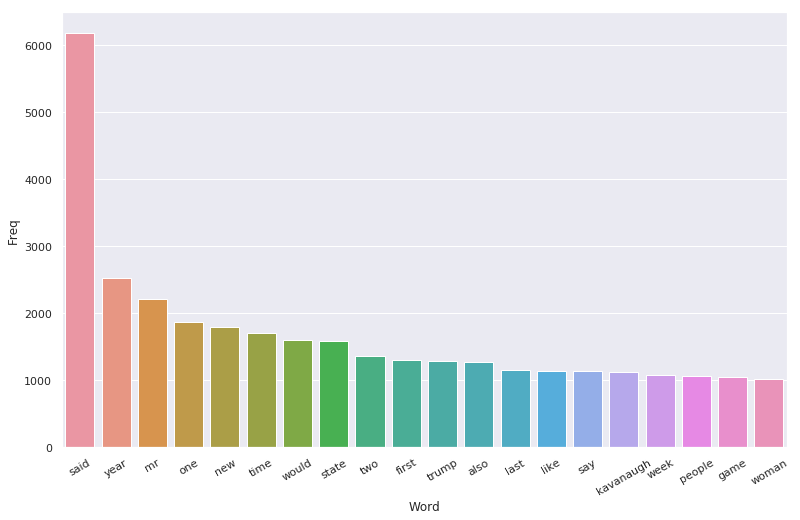

In [0]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
  
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                Bi-gram  Freq
0              new york   649
1          united state   548
2              year old   374
3       judge kavanaugh   363
4         supreme court   339
5              mr trump   336
6             last year   297
7             last week   236
8       brett kavanaugh   221
9        sexual assault   219
10         donald trump   202
11             year ago   182
12     president donald   166
13            dr blasey   164
14  judiciary committee   160
15          white house   157
16          high school   157
17        united nation   153
18      president trump   149
19       said statement   147


[Text(0, 0, 'new york'),
 Text(0, 0, 'united state'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'judge kavanaugh'),
 Text(0, 0, 'supreme court'),
 Text(0, 0, 'mr trump'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'last week'),
 Text(0, 0, 'brett kavanaugh'),
 Text(0, 0, 'sexual assault'),
 Text(0, 0, 'donald trump'),
 Text(0, 0, 'year ago'),
 Text(0, 0, 'president donald'),
 Text(0, 0, 'dr blasey'),
 Text(0, 0, 'judiciary committee'),
 Text(0, 0, 'white house'),
 Text(0, 0, 'high school'),
 Text(0, 0, 'united nation'),
 Text(0, 0, 'president trump'),
 Text(0, 0, 'said statement')]

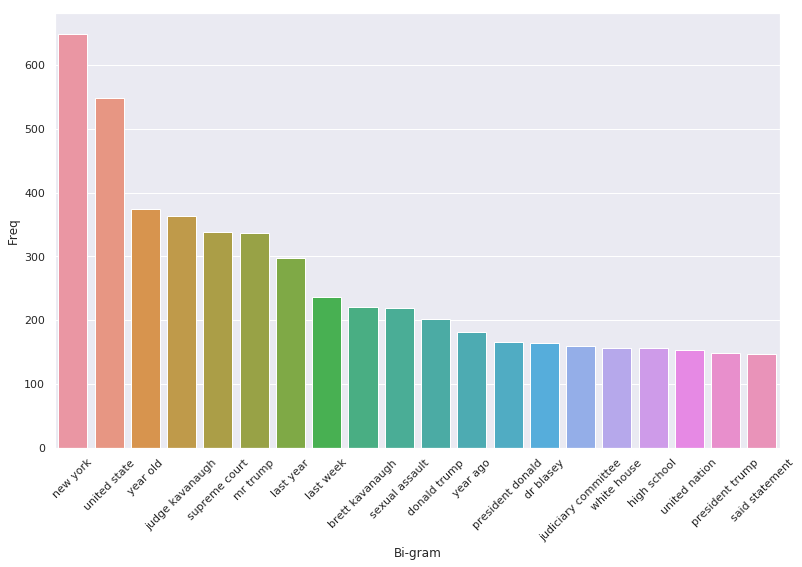

In [0]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
  
  
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)


                        Tri-gram  Freq
0         president donald trump   166
1          christine blasey ford   129
2                  new york time   122
3          supreme court nominee   109
4     senate judiciary committee    97
5          judge brett kavanaugh    76
6                  new york city    69
7        nominee brett kavanaugh    67
8            court nominee brett    66
9                  mr trump said    49
10            field level medium    40
11            senator jeff flake    34
12              first time since    33
13              le golf national    33
14                wild card game    33
15       respond request comment    32
16  security exchange commission    32
17     sexual assault allegation    30
18           united state mexico    28
19                  aung san suu    27


[Text(0, 0, 'president donald trump'),
 Text(0, 0, 'christine blasey ford'),
 Text(0, 0, 'new york time'),
 Text(0, 0, 'supreme court nominee'),
 Text(0, 0, 'senate judiciary committee'),
 Text(0, 0, 'judge brett kavanaugh'),
 Text(0, 0, 'new york city'),
 Text(0, 0, 'nominee brett kavanaugh'),
 Text(0, 0, 'court nominee brett'),
 Text(0, 0, 'mr trump said'),
 Text(0, 0, 'field level medium'),
 Text(0, 0, 'senator jeff flake'),
 Text(0, 0, 'first time since'),
 Text(0, 0, 'le golf national'),
 Text(0, 0, 'wild card game'),
 Text(0, 0, 'respond request comment'),
 Text(0, 0, 'security exchange commission'),
 Text(0, 0, 'sexual assault allegation'),
 Text(0, 0, 'united state mexico'),
 Text(0, 0, 'aung san suu')]

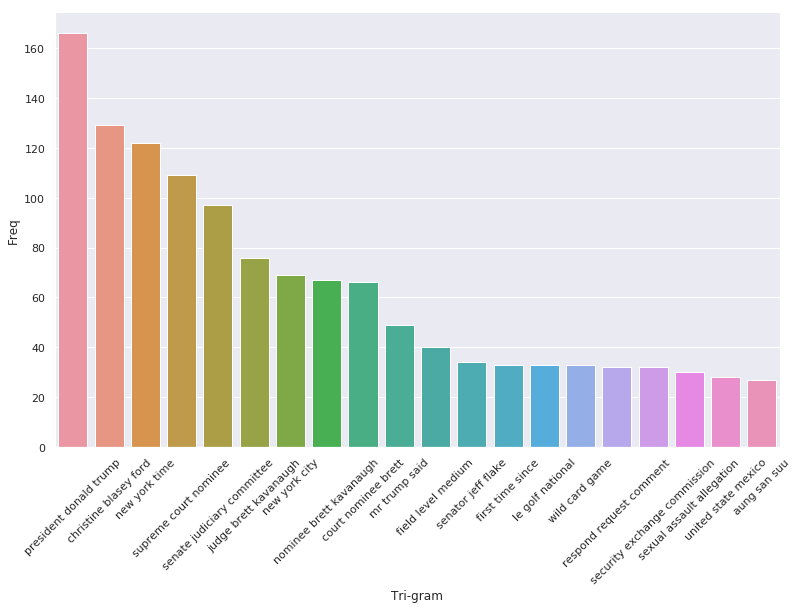

In [0]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
